In [1]:
# !pip install catboost optuna



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.8 MB/s eta 0:00:00










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.1 MB/s eta 0:00:00









     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00

















In [3]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

import optuna

from scipy.spatial.distance import pdist, squareform

import pickle

from scipy.sparse import csr_matrix, coo_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [2]:
datapath = './data/' # local
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
# datapath = r'/kaggle/input/drivendata-earthquake/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_test_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [3]:
def preprocess(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

def preprocess_autoencode(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

In [4]:
# Prep data for catboost
geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)
X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','object']:
        categorical_features_indices.append(i)
categorical_features = []
for colname,dtype in zip(X_train.columns,X_train.dtypes):
    if dtype in ['int64','object']:
        categorical_features.append(colname)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

### AutoEncode Geography (Pytorch)

#### Impute damage_grade of test features

In [70]:
# Create new dataframe with all info from both train and test sets, imputing damage grade
df_all = df_train_features.copy()
df_all = pd.concat([df_all,df_train_labels_raw],axis=1)
df_all = pd.concat([df_all,df_test_features.copy()],axis=0)

df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

# Fillna for damage_grade with means for geo level 3
damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

# Fillna for damage_grade with means for lowest geo level 2
damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

# Fillna for damage_grade with means for lowest geo level 2
damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

# Drop unwanted columns and one hot encode non-geo features
df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)
df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

# Get mean representation for each location
df_all = df_all.groupby(geo_features).mean().reset_index()
non_geo_features = [col for col in df_all.columns if not (col in geo_features)]
numerical_features = ['count_floors_pre_eq','age','area_percentage',
                      'height_percentage','count_families']
                      
non_geo_cat_features = list(set(non_geo_features) - set(numerical_features))


#### Geo-features only

Epoch 1/40:   0%|          | 0/5931 [00:00<?, ?it/s]

Epoch 1/40: 100%|██████████| 5931/5931 [00:04<00:00, 1237.13it/s]


Epoch [1/40], Loss: 16.353994054509705


Epoch 2/40: 100%|██████████| 5931/5931 [00:04<00:00, 1240.02it/s]


Epoch [2/40], Loss: 12.01073910248981


Epoch 3/40: 100%|██████████| 5931/5931 [00:04<00:00, 1259.61it/s]


Epoch [3/40], Loss: 9.493903105666154


Epoch 4/40: 100%|██████████| 5931/5931 [00:04<00:00, 1339.85it/s]


Epoch [4/40], Loss: 8.382500554353145


Epoch 5/40: 100%|██████████| 5931/5931 [00:04<00:00, 1313.89it/s]


Epoch [5/40], Loss: 7.728877203075786


Epoch 6/40: 100%|██████████| 5931/5931 [00:04<00:00, 1253.86it/s]


Epoch [6/40], Loss: 7.310906966788595


Epoch 7/40: 100%|██████████| 5931/5931 [00:04<00:00, 1248.18it/s]


Epoch [7/40], Loss: 7.034639271711383


Epoch 8/40: 100%|██████████| 5931/5931 [00:04<00:00, 1299.76it/s]


Epoch [8/40], Loss: 6.824835296867871


Epoch 9/40: 100%|██████████| 5931/5931 [00:04<00:00, 1291.31it/s]


Epoch [9/40], Loss: 6.58419656941469


Epoch 10/40: 100%|██████████| 5931/5931 [00:04<00:00, 1327.65it/s]


Epoch [10/40], Loss: 6.344987310138768


Epoch 11/40: 100%|██████████| 5931/5931 [00:04<00:00, 1315.42it/s]


Epoch [11/40], Loss: 6.051335427415771


Epoch 12/40: 100%|██████████| 5931/5931 [00:04<00:00, 1201.00it/s]


Epoch [12/40], Loss: 5.666174501336418


Epoch 13/40: 100%|██████████| 5931/5931 [00:04<00:00, 1275.49it/s]


Epoch [13/40], Loss: 5.256145166362885


Epoch 14/40: 100%|██████████| 5931/5931 [00:04<00:00, 1266.85it/s]


Epoch [14/40], Loss: 4.726351495795774


Epoch 15/40: 100%|██████████| 5931/5931 [00:04<00:00, 1239.38it/s]


Epoch [15/40], Loss: 4.171039634050848


Epoch 16/40: 100%|██████████| 5931/5931 [00:04<00:00, 1257.96it/s]


Epoch [16/40], Loss: 3.6450449868813894


Epoch 17/40: 100%|██████████| 5931/5931 [00:04<00:00, 1284.77it/s]


Epoch [17/40], Loss: 3.2104874902969187


Epoch 18/40: 100%|██████████| 5931/5931 [00:04<00:00, 1341.05it/s]


Epoch [18/40], Loss: 2.842484456301728


Epoch 19/40: 100%|██████████| 5931/5931 [00:04<00:00, 1331.67it/s]


Epoch [19/40], Loss: 2.499909663016248


Epoch 20/40: 100%|██████████| 5931/5931 [00:04<00:00, 1293.99it/s]


Epoch [20/40], Loss: 2.352124256599007


Epoch 21/40: 100%|██████████| 5931/5931 [00:04<00:00, 1340.86it/s]


Epoch [21/40], Loss: 2.1056925172072285


Epoch 22/40: 100%|██████████| 5931/5931 [00:04<00:00, 1355.86it/s]


Epoch [22/40], Loss: 2.0513603245407785


Epoch 23/40: 100%|██████████| 5931/5931 [00:04<00:00, 1283.50it/s]


Epoch [23/40], Loss: 1.9665120645575238


Epoch 24/40: 100%|██████████| 5931/5931 [00:04<00:00, 1319.55it/s]


Epoch [24/40], Loss: 1.9178790451462393


Epoch 25/40: 100%|██████████| 5931/5931 [00:04<00:00, 1309.72it/s]


Epoch [25/40], Loss: 1.8477026267553318


Epoch 26/40: 100%|██████████| 5931/5931 [00:04<00:00, 1328.63it/s]


Epoch [26/40], Loss: 1.7147060729986352


Epoch 27/40: 100%|██████████| 5931/5931 [00:04<00:00, 1314.59it/s]


Epoch [27/40], Loss: 1.7937254560994291


Epoch 28/40: 100%|██████████| 5931/5931 [00:04<00:00, 1338.21it/s]


Epoch [28/40], Loss: 1.7650303153322005


Epoch 29/40: 100%|██████████| 5931/5931 [00:04<00:00, 1310.55it/s]


Epoch [29/40], Loss: 1.6577156699912448


Epoch 30/40: 100%|██████████| 5931/5931 [00:04<00:00, 1265.78it/s]


Epoch [30/40], Loss: 1.647469015704115


Epoch 31/40: 100%|██████████| 5931/5931 [00:04<00:00, 1277.84it/s]


Epoch [31/40], Loss: 1.599313529408611


Epoch 32/40: 100%|██████████| 5931/5931 [00:04<00:00, 1328.68it/s]


Epoch [32/40], Loss: 1.6238302621737288


Epoch 33/40: 100%|██████████| 5931/5931 [00:04<00:00, 1296.89it/s]


Epoch [33/40], Loss: 1.618860690758434


Epoch 34/40: 100%|██████████| 5931/5931 [00:04<00:00, 1284.89it/s]


Epoch [34/40], Loss: 1.5536930665360646


Epoch 35/40: 100%|██████████| 5931/5931 [00:04<00:00, 1301.01it/s]


Epoch [35/40], Loss: 1.5352934828834843


Epoch 36/40: 100%|██████████| 5931/5931 [00:04<00:00, 1311.95it/s]


Epoch [36/40], Loss: 1.5588229218285994


Epoch 37/40: 100%|██████████| 5931/5931 [00:04<00:00, 1295.18it/s]


Epoch [37/40], Loss: 1.4764811866811023


Epoch 38/40: 100%|██████████| 5931/5931 [00:04<00:00, 1293.89it/s]


Epoch [38/40], Loss: 1.5290839074933413


Epoch 39/40: 100%|██████████| 5931/5931 [00:04<00:00, 1315.51it/s]


Epoch [39/40], Loss: 1.5281754802872423


Epoch 40/40: 100%|██████████| 5931/5931 [00:04<00:00, 1272.22it/s]


Epoch [40/40], Loss: 1.3815279456445264


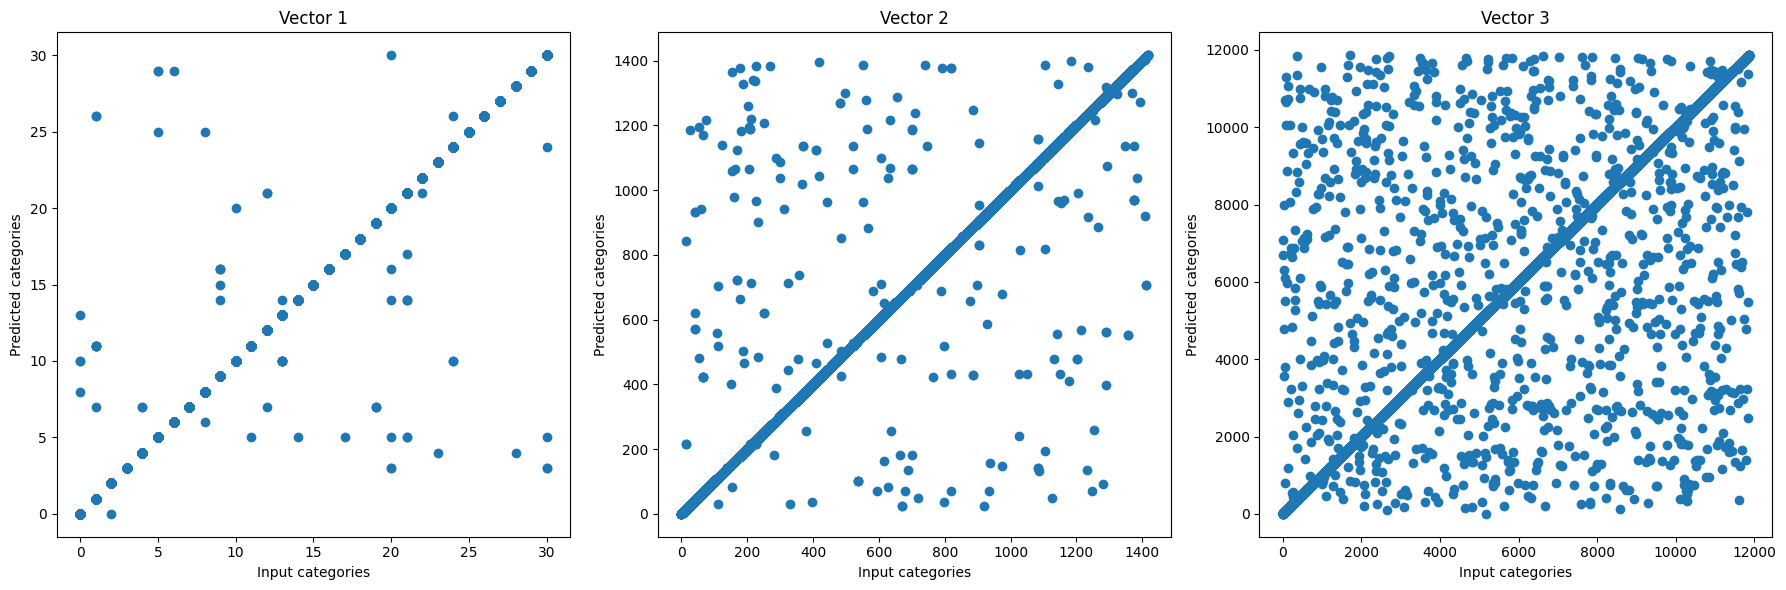

In [83]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    def __init__(self, latent_size=64):
        super(CategoricalAutoencoder, self).__init__()
        
        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, 16)
        self.embed2 = nn.Embedding(1418, 32)
        self.embed3 = nn.Embedding(11861, 64)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(16 + 32 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 16 + 32 + 64)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(16, 31)
        self.output2 = nn.Linear(32, 1418)
        self.output3 = nn.Linear(64, 11861)
        
    def forward(self, x1, x2, x3):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon = torch.split(x_recon, [16, 32, 64], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out

# Instantiate the model
model = CategoricalAutoencoder(latent_size=64).cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
df = df_all.iloc[:,:3].copy()

# Encode the categorical columns
le_cat1 = LabelEncoder()
le_cat2 = LabelEncoder()
le_cat3 = LabelEncoder()

df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

# Convert DataFrame to tensors
x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

dataset = TensorDataset(x1, x2, x3)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training loop with tqdm
epochs = 40
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
        x1_batch, x2_batch, x3_batch = batch
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x1_batch, x2_batch, x3_batch)
        
        # Compute the loss
        loss = criterion(outputs[0], x1_batch) + \
               criterion(outputs[1], x2_batch) + \
               criterion(outputs[2], x3_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')

# Pass the input through the encoder and plot the results
model.eval()
with torch.no_grad():
    z = model.encoder(torch.cat([model.embed1(x1), model.embed2(x2), model.embed3(x3)], dim=1))
    recon_x1, recon_x2, recon_x3 = model(x1, x2, x3)

# Plot the input categories against the predicted categories
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot for the first vector
axs[0].scatter(x1.cpu().numpy(), recon_x1.argmax(dim=1).cpu().numpy())
axs[0].set_xlabel('Input categories')
axs[0].set_ylabel('Predicted categories')
axs[0].set_title('Vector 1')

# Subplot for the second vector
axs[1].scatter(x2.cpu().numpy(), recon_x2.argmax(dim=1).cpu().numpy())
axs[1].set_xlabel('Input categories')
axs[1].set_ylabel('Predicted categories')
axs[1].set_title('Vector 2')

# Subplot for the third vector
axs[2].scatter(x3.cpu().numpy(), recon_x3.argmax(dim=1).cpu().numpy())
axs[2].set_xlabel('Input categories')
axs[2].set_ylabel('Predicted categories')
axs[2].set_title('Vector 3')

plt.tight_layout()
plt.show()


,geo_level_1_id,geo_level_2_id,geo_level_3_id,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
11554,29,1396,7908,10.080958,-2.349046,-0.419666,8.782059,-4.083117,1.237001,-4.042450,...,12.576180,-1.390774,3.871953,-0.175744,-1.187260,10.023973,-0.257898,14.096373,2.625245,5.004809
4869,11,147,10399,3.713536,1.184529,18.033558,-8.893159,2.264819,11.875748,-1.410654,...,6.982635,7.975469,1.192271,2.789548,7.732720,-4.459623,2.739330,4.991843,-5.381083,6.129521
8187,18,0,2439,2.397555,-2.561707,-13.532912,-4.110783,-3.538508,0.082571,2.506339,...,0.788146,14.728862,2.226279,-2.106429,0.551944,4.692014,-2.789779,-0.353189,-18.037525,-0.317065
4174,8,1414,12319,7.574819,6.947357,-9.565878,-2.854613,-4.910304,3.046438,3.320062,...,-5.087706,-8.934674,3.479598,4.028661,-3.251313,5.810728,-10.900990,11.646993,2.516607,3.696216
2813,6,1108,2852,7.715638,1.443174,-1.735681,7.281125,-5.494677,-6.200778,11.581404,...,-3.780507,-1.820866,6.753661,7.153756,2.007313,13.577587,-2.957490,6.258373,16.604715,5.503550


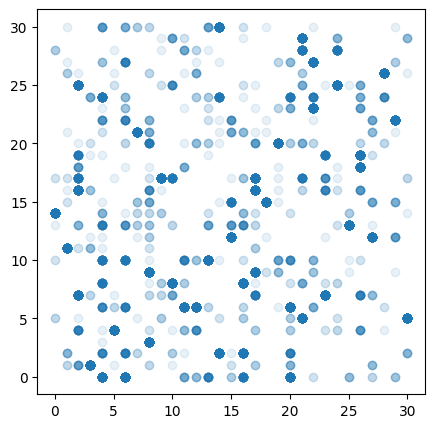

In [102]:
latent_geo = pd.concat([df_all[geo_features],pd.DataFrame(z.cpu().numpy())],axis=1)
latent_geo.sample(5)

np.random.seed(0)
num_samples = latent_geo.shape[0]
num_features = latent_geo.shape[1]-3
data = latent_geo.iloc[:,3:].to_numpy()

# Step 1: Normalize data (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Calculate cosine similarity-like metric (Euclidean distance in this case)
# Note: Cosine similarity is not directly applicable to numeric data, using Euclidean distance instead
# euclidean_sim = pairwise_distances(data_scaled, metric='euclidean')
cosine_sim = 1 - pairwise_distances(data_scaled, metric='cosine')

# Step 3: Apply K-means clustering
num_clusters = 31  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(cosine_sim)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(cluster_labels,latent_geo['geo_level_1_id'],alpha=0.1)

#### Geo-features + other categorical features

Epoch 1/40:   0%|          | 0/5931 [00:00<?, ?it/s]

Epoch 1/40: 100%|██████████| 5931/5931 [00:05<00:00, 1159.39it/s]


Epoch [1/40], Loss: 16.929088158061585


Epoch 2/40: 100%|██████████| 5931/5931 [00:05<00:00, 1182.18it/s]


Epoch [2/40], Loss: 13.389323775472015


Epoch 3/40: 100%|██████████| 5931/5931 [00:05<00:00, 1175.05it/s]


Epoch [3/40], Loss: 10.437772999121757


Epoch 4/40: 100%|██████████| 5931/5931 [00:04<00:00, 1186.75it/s]


Epoch [4/40], Loss: 8.974813991162975


Epoch 5/40: 100%|██████████| 5931/5931 [00:05<00:00, 1174.38it/s]


Epoch [5/40], Loss: 8.13768431963878


Epoch 6/40: 100%|██████████| 5931/5931 [00:05<00:00, 1172.12it/s]


Epoch [6/40], Loss: 7.6932107244127215


Epoch 7/40: 100%|██████████| 5931/5931 [00:04<00:00, 1215.40it/s]


Epoch [7/40], Loss: 7.424021677029432


Epoch 8/40: 100%|██████████| 5931/5931 [00:05<00:00, 1181.97it/s]


Epoch [8/40], Loss: 7.146254516576478


Epoch 9/40: 100%|██████████| 5931/5931 [00:04<00:00, 1220.00it/s]


Epoch [9/40], Loss: 6.967675874977324


Epoch 10/40: 100%|██████████| 5931/5931 [00:04<00:00, 1236.79it/s]


Epoch [10/40], Loss: 6.803122933840314


Epoch 11/40: 100%|██████████| 5931/5931 [00:04<00:00, 1218.18it/s]


Epoch [11/40], Loss: 6.641132728071844


Epoch 12/40: 100%|██████████| 5931/5931 [00:04<00:00, 1236.91it/s]


Epoch [12/40], Loss: 6.435902849786942


Epoch 13/40: 100%|██████████| 5931/5931 [00:04<00:00, 1244.20it/s]


Epoch [13/40], Loss: 6.213007976209468


Epoch 14/40: 100%|██████████| 5931/5931 [00:04<00:00, 1214.00it/s]


Epoch [14/40], Loss: 5.987536329532972


Epoch 15/40: 100%|██████████| 5931/5931 [00:05<00:00, 1171.18it/s]


Epoch [15/40], Loss: 5.676264937612182


Epoch 16/40: 100%|██████████| 5931/5931 [00:05<00:00, 1175.19it/s]


Epoch [16/40], Loss: 5.391391325360747


Epoch 17/40: 100%|██████████| 5931/5931 [00:05<00:00, 1171.23it/s]


Epoch [17/40], Loss: 5.010503402951483


Epoch 18/40: 100%|██████████| 5931/5931 [00:04<00:00, 1191.92it/s]


Epoch [18/40], Loss: 4.733700447580305


Epoch 19/40: 100%|██████████| 5931/5931 [00:05<00:00, 1174.08it/s]


Epoch [19/40], Loss: 4.290994838420619


Epoch 20/40: 100%|██████████| 5931/5931 [00:05<00:00, 1170.61it/s]


Epoch [20/40], Loss: 3.9658435330263724


Epoch 21/40: 100%|██████████| 5931/5931 [00:05<00:00, 1173.64it/s]


Epoch [21/40], Loss: 3.585646547586602


Epoch 22/40: 100%|██████████| 5931/5931 [00:04<00:00, 1192.64it/s]


Epoch [22/40], Loss: 3.210135363776423


Epoch 23/40: 100%|██████████| 5931/5931 [00:04<00:00, 1207.74it/s]


Epoch [23/40], Loss: 2.9904566910476866


Epoch 24/40: 100%|██████████| 5931/5931 [00:05<00:00, 1161.05it/s]


Epoch [24/40], Loss: 2.78587919188096


Epoch 25/40: 100%|██████████| 5931/5931 [00:04<00:00, 1217.06it/s]


Epoch [25/40], Loss: 2.6598500543639365


Epoch 26/40: 100%|██████████| 5931/5931 [00:04<00:00, 1211.07it/s]


Epoch [26/40], Loss: 2.4133516276142704


Epoch 27/40: 100%|██████████| 5931/5931 [00:04<00:00, 1212.73it/s]


Epoch [27/40], Loss: 2.3511560700691616


Epoch 28/40: 100%|██████████| 5931/5931 [00:04<00:00, 1216.11it/s]


Epoch [28/40], Loss: 2.2112877118449767


Epoch 29/40: 100%|██████████| 5931/5931 [00:05<00:00, 1180.34it/s]


Epoch [29/40], Loss: 2.168064122591873


Epoch 30/40: 100%|██████████| 5931/5931 [00:04<00:00, 1220.99it/s]


Epoch [30/40], Loss: 2.1070117910248336


Epoch 31/40: 100%|██████████| 5931/5931 [00:04<00:00, 1236.94it/s]


Epoch [31/40], Loss: 2.1047220365027735


Epoch 32/40: 100%|██████████| 5931/5931 [00:04<00:00, 1198.08it/s]


Epoch [32/40], Loss: 2.0710254563876416


Epoch 33/40: 100%|██████████| 5931/5931 [00:04<00:00, 1196.62it/s]


Epoch [33/40], Loss: 1.9912787226041728


Epoch 34/40: 100%|██████████| 5931/5931 [00:05<00:00, 1159.96it/s]


Epoch [34/40], Loss: 2.083517030539182


Epoch 35/40: 100%|██████████| 5931/5931 [00:05<00:00, 1173.52it/s]


Epoch [35/40], Loss: 2.000599814017018


Epoch 36/40: 100%|██████████| 5931/5931 [00:04<00:00, 1213.70it/s]


Epoch [36/40], Loss: 1.9626270219514383


Epoch 37/40: 100%|██████████| 5931/5931 [00:05<00:00, 1178.87it/s]


Epoch [37/40], Loss: 1.9957210488085555


Epoch 38/40: 100%|██████████| 5931/5931 [00:05<00:00, 1174.39it/s]


Epoch [38/40], Loss: 1.903333380142585


Epoch 39/40: 100%|██████████| 5931/5931 [00:05<00:00, 1175.40it/s]


Epoch [39/40], Loss: 1.8969596173926515


Epoch 40/40: 100%|██████████| 5931/5931 [00:05<00:00, 1164.81it/s]


Epoch [40/40], Loss: 1.9815709768836391


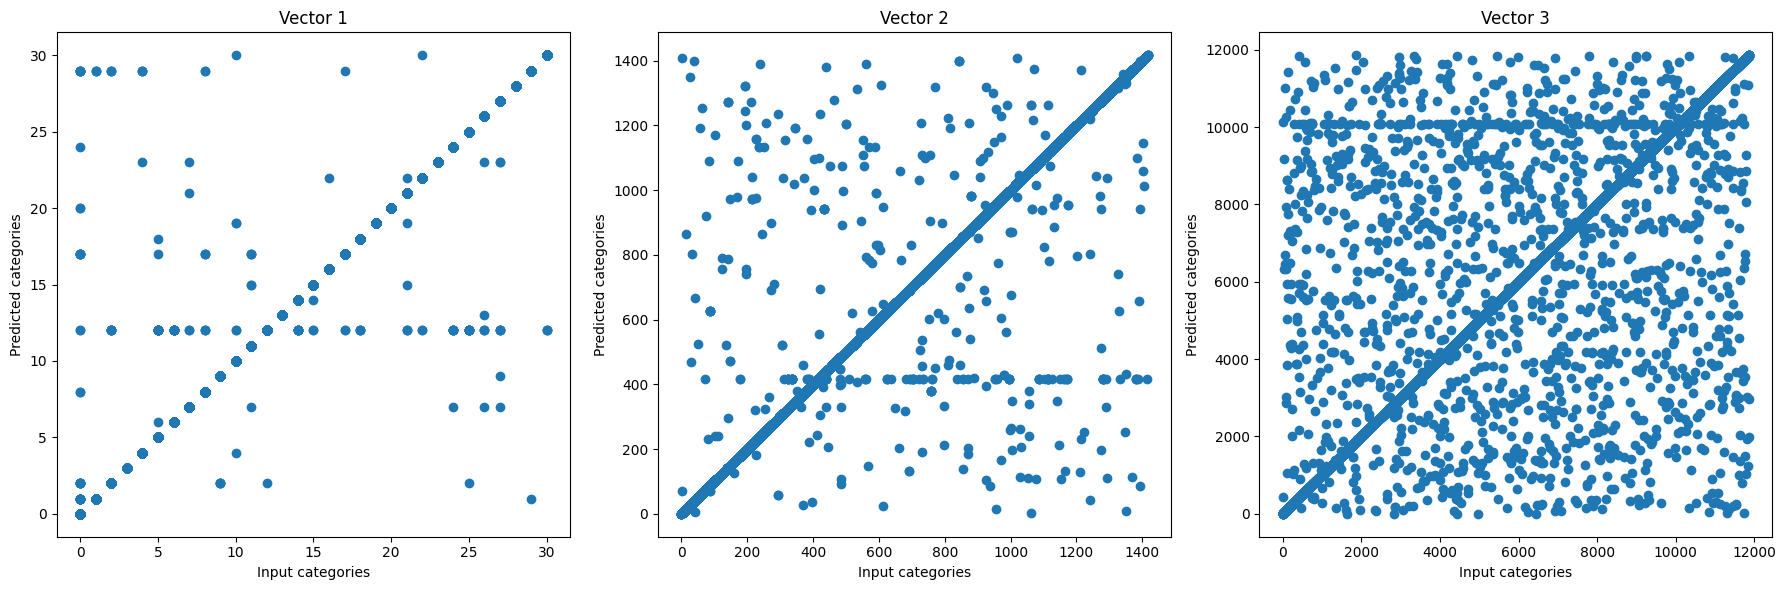

In [103]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    def __init__(self, latent_size=64):
        super(CategoricalAutoencoder, self).__init__()
        
        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, 16)
        self.embed2 = nn.Embedding(1418, 32)
        self.embed3 = nn.Embedding(11861, 64)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(16 + 32 + 64 + 58, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 16 + 32 + 64 + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(16, 31)
        self.output2 = nn.Linear(32, 1418)
        self.output3 = nn.Linear(64, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [16, 32, 64, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

# Instantiate the model
model = CategoricalAutoencoder(latent_size=64).cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
df = df_all.copy()

# Encode the categorical columns
le_cat1 = LabelEncoder()
le_cat2 = LabelEncoder()
le_cat3 = LabelEncoder()

df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

# Convert DataFrame to tensors
x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()
feat_tensor = torch.tensor(df[non_geo_features].values, dtype=torch.float).cuda()

# Create DataLoader
dataset = TensorDataset(x1, x2, x3, feat_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training loop with tqdm
epochs = 40
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
        x1_batch, x2_batch, x3_batch, feats_batch = batch
        optimizer.zero_grad()
        
        # Forward pass
        x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
        
        # Compute the loss
        loss = criterion(x1_out, x1_batch) + \
               criterion(x2_out, x2_batch) + \
               criterion(x3_out, x3_batch)
        
        loss_feat = nn.MSELoss()(feats_recon, feats_batch)

        total_loss = loss + loss_feat

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


# Pass the input through the encoder and plot the results
model.eval()
with torch.no_grad():
    x1, x2, x3, feat_tensor = x1, x2, x3, feat_tensor
    z = model.encoder(torch.cat([model.embed1(x1), model.embed2(x2), model.embed3(x3), feat_tensor], dim=1))
    recon_x1, recon_x2, recon_x3, feat_recon = model(x1, x2, x3, feat_tensor)


# Plot the input categories against the predicted categories
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot for the first vector
axs[0].scatter(x1.cpu().numpy(), recon_x1.argmax(dim=1).cpu().numpy())
axs[0].set_xlabel('Input categories')
axs[0].set_ylabel('Predicted categories')
axs[0].set_title('Vector 1')

# Subplot for the second vector
axs[1].scatter(x2.cpu().numpy(), recon_x2.argmax(dim=1).cpu().numpy())
axs[1].set_xlabel('Input categories')
axs[1].set_ylabel('Predicted categories')
axs[1].set_title('Vector 2')

# Subplot for the third vector
axs[2].scatter(x3.cpu().numpy(), recon_x3.argmax(dim=1).cpu().numpy())
axs[2].set_xlabel('Input categories')
axs[2].set_ylabel('Predicted categories')
axs[2].set_title('Vector 3')

plt.tight_layout()
plt.show()

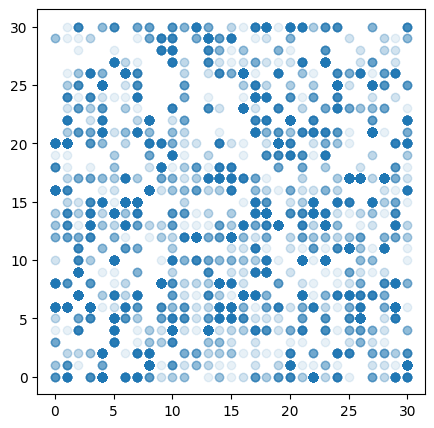

In [104]:
latent_geo = pd.concat([df_all[geo_features],pd.DataFrame(z.cpu().numpy())],axis=1)
latent_geo.sample(5)

np.random.seed(0)
num_samples = latent_geo.shape[0]
num_features = latent_geo.shape[1]-3
data = latent_geo.iloc[:,3:].to_numpy()

# Step 1: Normalize data (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Calculate cosine similarity-like metric (Euclidean distance in this case)
# Note: Cosine similarity is not directly applicable to numeric data, using Euclidean distance instead
# euclidean_sim = pairwise_distances(data_scaled, metric='euclidean')
cosine_sim = 1 - pairwise_distances(data_scaled, metric='cosine')

# Step 3: Apply K-means clustering
num_clusters = 31  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(cosine_sim)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(cluster_labels,latent_geo['geo_level_1_id'],alpha=0.1)

In [31]:
# Assume df_all, geo_features, and non_geo_features are defined
df = df_all.copy()

# Encode each categorical feature as integer indices
label_encoders = {}
for column in geo_features:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Standardize numerical features
scaler = StandardScaler()
df[non_geo_features] = scaler.fit_transform(df[non_geo_features])

# Prepare the input data
X_categorical = df[geo_features].values
X_numerical = df[non_geo_features].values

# Define the embedding dimensions (can be tuned)
embedding_dim1 = 64
embedding_dim2 = 64
embedding_dim3 = 64
latent_size = 2

class Autoencoder(nn.Module):
    def __init__(self, num_classes, embedding_dims, num_numerical_features, latent_size):
        super(Autoencoder, self).__init__()
        
        # Embedding layers for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_classes[0], embedding_dims[0]),
            nn.Embedding(num_classes[1], embedding_dims[1]),
            nn.Embedding(num_classes[2], embedding_dims[2])
        ])
        
        self.flatten = nn.Flatten()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(sum(embedding_dims) + num_numerical_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, latent_size)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        
        # Output layers for each categorical feature and numerical features
        self.output_categorical = nn.ModuleList([
            nn.Linear(128, num_classes[0]),
            nn.Linear(128, num_classes[1]),
            nn.Linear(128, num_classes[2])
        ])
        
        self.output_numerical = nn.Linear(128, num_numerical_features)
        
    def forward(self, x_categorical, x_numerical):
        embedded = [self.flatten(embedding(x)) for embedding, x in zip(self.embeddings, x_categorical)]
        concatenated_embeddings = torch.cat(embedded, dim=1)
        combined_inputs = torch.cat([concatenated_embeddings, x_numerical], dim=1)
        
        encoded = self.encoder(combined_inputs)
        decoded = self.decoder(encoded)
        
        output_categorical = [output(decoded) for output in self.output_categorical]
        output_numerical = self.output_numerical(decoded)
        
        return output_categorical + [output_numerical]

# Instantiate the model
num_classes = [len(le.classes_) for le in label_encoders.values()]
num_numerical_features = len(non_geo_features)
model = Autoencoder(num_classes, [embedding_dim1, embedding_dim2, embedding_dim3], num_numerical_features, latent_size)

# Define the loss functions and optimizer
criterion_categorical = nn.CrossEntropyLoss()
criterion_numerical = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the input data for training
X_categorical_tensors = [torch.tensor(X_categorical[:, i], dtype=torch.long) for i in range(X_categorical.shape[1])]
X_numerical_tensor = torch.tensor(X_numerical, dtype=torch.float32)

# Prepare the target data
y_categorical_tensors = [torch.tensor(df[col].values, dtype=torch.long) for col in geo_features]
y_numerical_tensor = torch.tensor(df[non_geo_features].values, dtype=torch.float32)

# Training loop (simplified)
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_categorical_tensors, X_numerical_tensor)
    loss = sum(criterion_categorical(output, target) for output, target in zip(outputs[:-1], y_categorical_tensors)) * 10000.0
    loss += criterion_numerical(outputs[-1], y_numerical_tensor)
    
    loss.backward()
    optimizer.step()
    
    # print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
    # Add progress tracking
    tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/200, Loss: 200850.71875
Epoch 2/200, Loss: 200798.46875
Epoch 3/200, Loss: 200749.765625
Epoch 4/200, Loss: 200703.515625
Epoch 5/200, Loss: 200659.0
Epoch 6/200, Loss: 200615.625
Epoch 7/200, Loss: 200572.671875
Epoch 8/200, Loss: 200529.71875
Epoch 9/200, Loss: 200486.421875
Epoch 10/200, Loss: 200442.515625
Epoch 11/200, Loss: 200397.734375
Epoch 12/200, Loss: 200352.0625
Epoch 13/200, Loss: 200305.0625
Epoch 14/200, Loss: 200256.65625
Epoch 15/200, Loss: 200206.796875
Epoch 16/200, Loss: 200155.609375
Epoch 17/200, Loss: 200102.921875
Epoch 18/200, Loss: 200049.21875
Epoch 19/200, Loss: 199994.515625
Epoch 20/200, Loss: 199939.1875
Epoch 21/200, Loss: 199883.15625
Epoch 22/200, Loss: 199826.84375
Epoch 23/200, Loss: 199770.515625
Epoch 24/200, Loss: 199714.28125
Epoch 25/200, Loss: 199658.625
Epoch 26/200, Loss: 199603.65625
Epoch 27/200, Loss: 199549.0
Epoch 28/200, Loss: 199494.796875
Epoch 29/200, Loss: 199441.0
Epoch 30/200, Loss: 199387.78125
Epoch 31/200, Loss: 199333

In [32]:
temp_out = model(X_categorical_tensors, X_numerical_tensor)

In [33]:
temp_out[0]

tensor([[ 24.3714,  14.3358, -51.1015,  ..., -36.4329,  -3.7376, -26.1888],
        [ 24.7534,  14.8298, -52.4202,  ..., -37.2798,  -3.6913, -26.6448],
        [ 25.5853,  14.8568, -55.4382,  ..., -39.7181,  -4.9865, -28.7276],
        ...,
        [-38.9951,  -3.0382,  18.4809,  ...,  20.5247,   8.4619,  22.5445],
        [-27.5501,  -1.6169,  15.9488,  ...,  16.8523,   8.1668,  18.0984],
        [-52.0223,  -5.0248,  21.8344,  ...,  24.8455,   8.3531,  27.4456]],
       grad_fn=<AddmmBackward0>)

In [34]:
torch.argmin(temp_out[0],axis=1).unique()

tensor([ 0,  2, 10, 15])

0.0


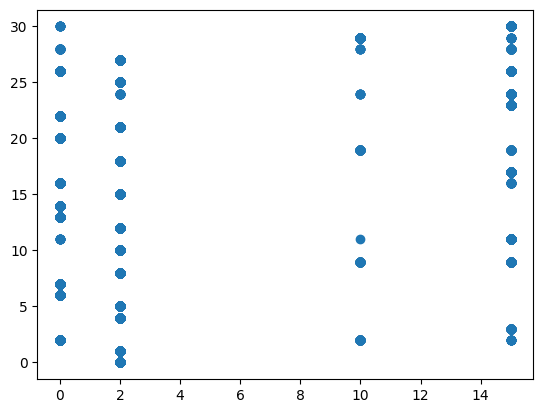

In [35]:
# plt.scatter(temp_out[:,0],temp_inp[:,0])

y_pred,y_true = torch.argmin(temp_out[0],axis=1),y_categorical_tensors[0]
plt.scatter(y_pred,y_true);
print(accuracy_score(y_pred,y_true))

0.5904223927156226


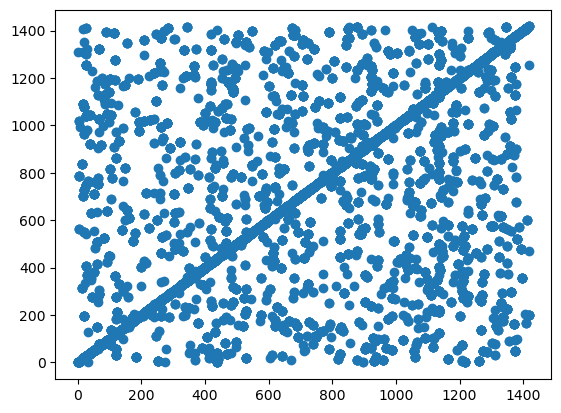

In [37]:
# plt.scatter(temp_out[:,1],temp_inp[:,1])

y_pred,y_true = np.argmax(temp_out[1],axis=1),y_categorical[1]
plt.scatter(y_pred,y_true);
print(accuracy_score(y_pred,y_true))

0.08388837366157997


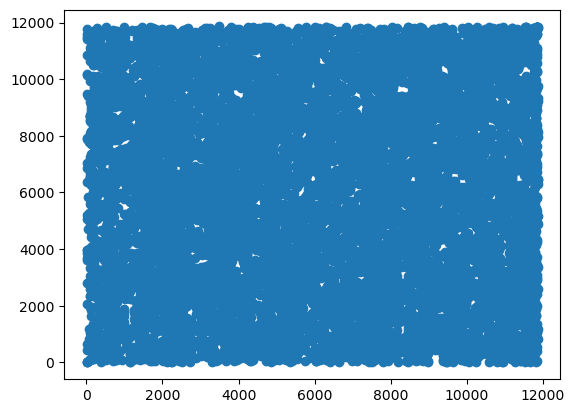

In [38]:
# plt.scatter(temp_out[:,2],temp_inp[:,2])

y_pred,y_true = np.argmax(temp_out[2],axis=1),y_categorical[2]
plt.scatter(y_pred,y_true);
print(accuracy_score(y_pred,y_true))

In [39]:
# Get latent values
# Define the intermediate model that outputs the latent space
latent_space_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)
latent_space_values = latent_space_model.predict(X)

371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [40]:
# Check clustering
num_clusters = 31  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_space_values)

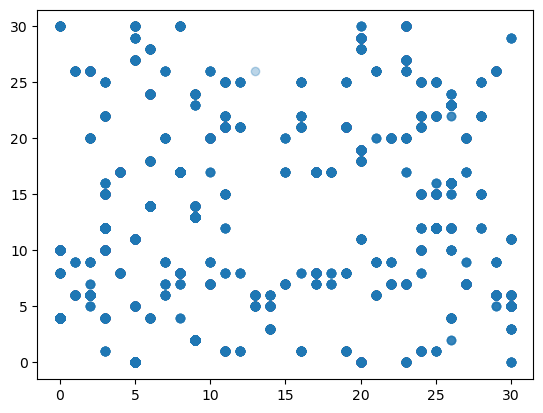

In [41]:
plt.scatter(cluster_labels,y_categorical[0],alpha=0.3)

## CatBoost Training

### First Attempt

In [ ]:
# # Instantiate catboost regressor model
# model = cb.CatBoostRegressor(loss_function='RMSE')

# # Grid search training
# grid = {'iterations': [100, 150, 200],
#         'learning_rate': [0.03, 0.1],
#         'depth': [2, 4, 6, 8],
#         'l2_leaf_reg': [0.2, 0.5, 1, 3]}
# model.grid_search(grid, train_dataset)

0:	learn: 2.2553502	test: 2.2560586	best: 2.2560586 (0)	total: 367ms	remaining: 36.3s

1:	learn: 2.1922772	test: 2.1929840	best: 2.1929840 (1)	total: 477ms	remaining: 23.4s

2:	learn: 2.1305542	test: 2.1312584	best: 2.1312584 (2)	total: 590ms	remaining: 19.1s

3:	learn: 2.0707731	test: 2.0716203	best: 2.0716203 (3)	total: 785ms	remaining: 18.8s

4:	learn: 2.0128228	test: 2.0136105	best: 2.0136105 (4)	total: 869ms	remaining: 16.5s

5:	learn: 1.9567082	test: 1.9576252	best: 1.9576252 (5)	total: 938ms	remaining: 14.7s

6:	learn: 1.9024358	test: 1.9034904	best: 1.9034904 (6)	total: 1s	remaining: 13.3s

7:	learn: 1.8502817	test: 1.8513965	best: 1.8513965 (7)	total: 1.07s	remaining: 12.4s

8:	learn: 1.7994752	test: 1.8006884	best: 1.8006884 (8)	total: 1.14s	remaining: 11.5s

9:	learn: 1.7502540	test: 1.7515714	best: 1.7515714 (9)	total: 1.2s	remaining: 10.8s

10:	learn: 1.7031167	test: 1.7044380	best: 1.7044380 (10)	total: 1.27s	remaining: 10.3s

11:	learn: 1.6575988	test: 1.6589211	best: 1.

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
# # Evaluation
# pred = model.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)

# print('Testing performance')
# print(f'RMSE: {rmse:.2f}')
# print(f'R2: {r2:.2f}')

Testing performance

RMSE: 0.45

R2: 0.47


In [ ]:
# import pickle
# with open('earthquake_cb_model_1.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [ ]:
# pred_int = np.round(pred)
# # (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
# f1_score(y_test,pred_int,average='micro')
# # f1_score(y_test,pred_int)

0.7344256633602578

<BarContainer object of 38 artists>

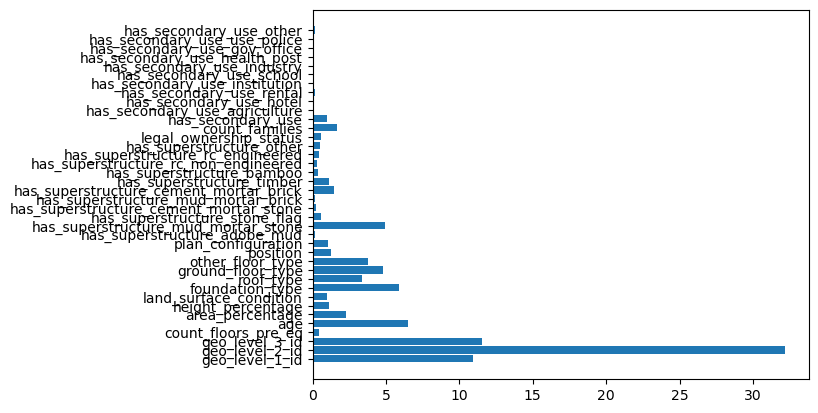

In [ ]:
# feature_importance_vals = model.get_feature_importance()
# plt.barh(X_train.columns,feature_importance_vals)


### OPTUNA

In [6]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        'depth': trial.suggest_int('depth', 3, 10),
        'random_seed': 42,
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter
        'loss_function': 'RMSE',
        'od_type': 'Iter',
        'od_wait': 50,
        'task_type': 'GPU',  # Use GPU for training
        'verbose': False  # Disable CatBoost verbose output
    }

    model = cb.CatBoostRegressor(**params)
    model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=50, verbose_eval=False)

    y_pred = model.predict(val_dataset)
    score = mean_squared_error(y_val, y_pred, squared=False)
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

[I 2024-06-20 00:31:27,101] A new study created in memory with name: no-name-ec61d895-1c52-4f26-9033-872d4b980ff8


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:03,759] Trial 0 finished with value: 0.4970125176108661 and parameters: {'iterations': 160, 'learning_rate': 0.006669755518856318, 'depth': 7, 'l2_leaf_reg': 83.38317923225196}. Best is trial 0 with value: 0.4970125176108661.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:23,851] Trial 1 finished with value: 0.4475284467535261 and parameters: {'iterations': 517, 'learning_rate': 0.06001707318708533, 'depth': 8, 'l2_leaf_reg': 0.00020695187983015833}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:47,005] Trial 2 finished with value: 0.4480076937361499 and parameters: {'iterations': 425, 'learning_rate': 0.041364305052773165, 'depth': 10, 'l2_leaf_reg': 0.0024890666749060692}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:10,722] Trial 3 finished with value: 0.5420428223065008 and parameters: {'iterations': 706, 'learning_rate': 0.0005739359709736625, 'depth': 8, 'l2_leaf_reg': 19.962838759027225}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:18,951] Trial 4 finished with value: 0.5895482111192502 and parameters: {'iterations': 221, 'learning_rate': 0.0004762801045277096, 'depth': 8, 'l2_leaf_reg': 20.704521766426264}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:27,200] Trial 5 finished with value: 0.45956202657429823 and parameters: {'iterations': 535, 'learning_rate': 0.023207225639048923, 'depth': 3, 'l2_leaf_reg': 0.06320062517442655}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:34,947] Trial 6 finished with value: 0.45509489145952464 and parameters: {'iterations': 249, 'learning_rate': 0.040999107520008536, 'depth': 6, 'l2_leaf_reg': 0.3647707766313438}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:50,909] Trial 7 finished with value: 0.4597167537828126 and parameters: {'iterations': 430, 'learning_rate': 0.00726393356433904, 'depth': 8, 'l2_leaf_reg': 0.0162411445823464}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:58,075] Trial 8 finished with value: 0.4576006175229995 and parameters: {'iterations': 264, 'learning_rate': 0.031181906098745958, 'depth': 5, 'l2_leaf_reg': 4.7939000201651754e-05}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:05,116] Trial 9 finished with value: 0.4536869033507849 and parameters: {'iterations': 449, 'learning_rate': 0.14437729793670398, 'depth': 3, 'l2_leaf_reg': 3.522010803785723}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:16,657] Trial 10 finished with value: 0.44831727583625347 and parameters: {'iterations': 936, 'learning_rate': 0.24530882427328932, 'depth': 10, 'l2_leaf_reg': 7.202291881562506e-08}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:23,575] Trial 11 finished with value: 0.45177698030126034 and parameters: {'iterations': 683, 'learning_rate': 0.4286877153038693, 'depth': 10, 'l2_leaf_reg': 4.013209502235e-05}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:57,388] Trial 12 finished with value: 0.46156664667501546 and parameters: {'iterations': 653, 'learning_rate': 0.0035663829423760573, 'depth': 10, 'l2_leaf_reg': 0.0002644439196696404}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[W 2024-06-20 00:35:06,498] Trial 13 failed with parameters: {'iterations': 349, 'learning_rate': 0.0764756880515819, 'depth': 9, 'l2_leaf_reg': 4.7108064491623973e-07} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/3320020667.py", line 16, in objective
    model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=50, verbose_eval=False)
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2400, in _fit
    self._train(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1780, in _train
    self._object._train(train_pool, tes

KeyboardInterrupt: 

In [7]:
# Load study
with open(datapath+'optuna_study.pkl', 'rb') as file:
    study = pickle.load(file)
    
# Print the best parameters and score
best_params = study.best_params
best_score = study.best_value

print('Best parameters found:')
print(best_params)
print('Best RMSE found: {:.4f}'.format(best_score))

# Train the final model with the best parameters on the entire dataset

final_train_pool = cb.Pool(X_train_or, y_train_or, cat_features=categorical_features_indices)
final_model = cb.CatBoostRegressor(**best_params, task_type='GPU', verbose=False)
final_model.fit(final_train_pool, verbose_eval=False)

# Evaluate on hold out
predictions = final_model.predict(X_test)

Best parameters found:
{'iterations': 987, 'learning_rate': 0.06594606333962763, 'depth': 10, 'l2_leaf_reg': 5.1486658327264455e-05}
Best RMSE found: 0.4434
Example predictions:
[2.08831371 2.68991622 2.69258255 ... 2.56914313 1.93965214 2.57058941]


In [8]:
pred_int = np.round(predictions)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0.7476145404313014

<BarContainer object of 38 artists>

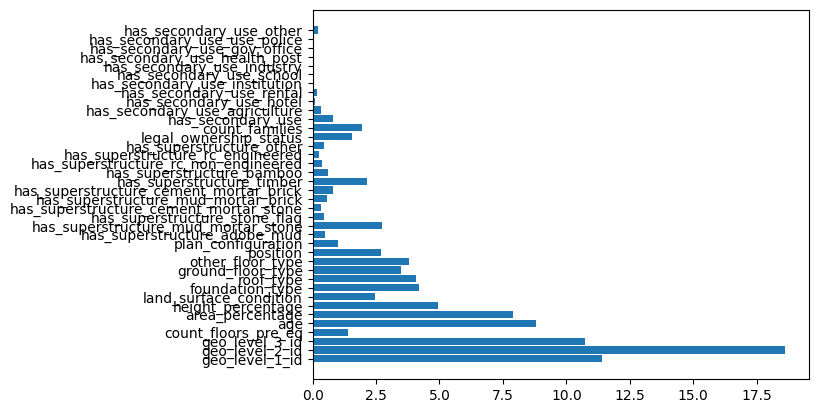

In [9]:
feature_importance_vals = final_model.get_feature_importance()
plt.barh(X_train.columns,feature_importance_vals)

In [ ]:
# model_filename = '/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/optuna_study.pkl'

# # Save the model to file
# with open(model_filename, 'wb') as f:
#     pickle.dump(study, f)

### AutoEncoder Enhanced